# Google AI Open Images

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import cv2
from PIL import Image, ImageColor, ImageDraw, ImageFont
import cv2, os, glob, time
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Concatenate, Conv2D,
    Input, Lambda, LeakyReLU,
    MaxPool2D, UpSampling2D, ZeroPadding2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings(action="ignore")

In [11]:
print(os.listdir("../input"))

['google-ai-open-images-object-detection-track']


In [12]:
print(os.listdir("../input/google-ai-open-images-object-detection-track"))

['sample_submission.csv', 'test']


In [13]:
DIR_PATH = '../input/google-ai-open-images-object-detection-track/'


In [64]:
all_image_paths = [DIR_PATH + 'test/' + x for x in os.listdir(DIR_PATH + 'test/')]

all_image_ids   = list(path.split(DIR_PATH+'test/')[1][:-4] for path in all_image_paths)


In [60]:
print('len(all_image_paths):', len(all_image_paths))
print('len(all_image_ids)  :', len(all_image_ids))

len(all_image_paths): 99999
len(all_image_ids)  : 99999


In [16]:
def show_image(i):
    plt.imshow(Image.open(all_image_paths[i]))

In [17]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

YOLOV3_TINY_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
]

In [18]:
yolo_anchors = np.array([
    (10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
    (59, 119), (116, 90), (156, 198), (373, 326)],
    np.float32) / 416

yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

yolo_tiny_anchors = np.array([
    (10, 14), (23, 27), (37, 58),
    (81, 82), (135, 169), (344, 319)],
    np.float32) / 416

yolo_tiny_anchor_masks = np.array([[3, 4, 5], [0, 1, 2]])

In [19]:
class_names = [
    'person', 'bicycle','car','motorbike','aeroplane','bus','train','truck','boat',
    'traffic light','fire hydrant','stop sign','parking meter','bench',
    'bird','cat','dog','horse','sheep','cow','elephant','bear','zebra',
    'giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee',
    'skis','snowboard','sports ball','kite','baseball bat','baseball glove',
    'skateboard','surfboard','tennis racket','bottle','wine glass','cup',
    'fork','knife','spoon','bowl','banana','apple','sandwich','orange',
    'broccoli','carrot','hot dog','pizza','donut','cake','chair','sofa',
    'pottedplant','bed','diningtable','toilet','tvmonitor','laptop','mouse',
    'remote','keyboard','cell phone','microwave','oven','toaster','sink',
    'refrigerator','book','clock','vase','scissors','teddy bear',
    'hair drier','toothbrush'
]

In [20]:
def load_darknet_weights(model, weights_file, tiny = False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLOV3_TINY_LAYER_LIST if tiny else YOLOV3_LAYER_LIST
    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i+1 < len(sub_model.layers) and \
               sub_model.layers[i+1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i+1]
            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters). \
                             reshape((4, filters))[[1, 0, 2, 3]]
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape)). \
                           reshape(conv_shape).transpose([2, 3, 1, 0])
            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)
    wf.close()

In [21]:
def broadcast_iou(box_1, box_2):
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)
    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) - \
            tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) - \
            tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * (box_2[..., 3] - box_2[..., 1])
    iou =  int_area / (box_1_area + box_2_area - int_area)
    return iou

In [22]:
def freeze_all(model, frozen = True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [23]:
def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(class_names[int(classes[i])], objectness[i]),
                          x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

In [24]:
def draw_labels(x, y, class_names):
    img = x.numpy()
    boxes, classes = tf.split(y, (4, 1), axis = -1)
    classes = classes[..., 0]
    wh = np.flip(img.shape[0 : 2])
    for i in range(len(boxes)):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, class_names[classes[i]],
                          x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 8, (0, 0, 255), 2)
    return img

In [25]:
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

In [26]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):
    N = tf.shape(y_true)[0]
    y_true_out  = tf.zeros((N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))
    anchor_idxs = tf.cast(anchor_idxs, tf.int32)
    indexes = tf.TensorArray(tf.int32,   1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))
            if not tf.reduce_any(anchor_eq):
                continue
            box = y_true[i][j][0:4]
            box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2
            anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
            grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)
            indexes = indexes.write(idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
            updates = updates.write(idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
            idx += 1
    return tf.tensor_scatter_nd_update(y_true_out, indexes.stack(), updates.stack())

In [27]:
def transform_targets(y_train, anchors, anchor_masks, classes):
    y_outs = []
    grid_size = 13
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2), (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
                   tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)
    y_train = tf.concat([y_train, anchor_idx], axis=-1)
    for anchor_idxs in anchor_masks:
        y_out = transform_targets_for_output(y_train, grid_size, anchor_idxs, classes)
        y_outs.append(y_out)
        grid_size *= 2
    return tuple(y_outs)

In [28]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    def call(self, x, training = False):
        if training is None:
            traininig = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [29]:
def DarknetConv(x, filters, kernel_size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        padding = 'valid'
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)
    x = Conv2D(filters=filters, 
               kernel_size=kernel_size,
               strides=strides, 
               padding=padding,
               use_bias=not batch_norm, 
               kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

In [30]:
def DarknetResidual(x, filters):
    prev_x = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev_x, x])
    return x

In [31]:
def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

In [32]:
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)
    x = x_36 = DarknetBlock(x, 256, 8)
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [33]:
def DarknetTiny(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 16, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 32, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 64, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 128, 3)
    x = MaxPool2D(2, 2, 'same')(x)
    x = x_8 = DarknetConv(x, 256, 3)  # skip connection
    x = MaxPool2D(2, 2, 'same')(x)
    x = DarknetConv(x, 512, 3)
    x = MaxPool2D(2, 1, 'same')(x)
    x = DarknetConv(x, 1024, 3)
    return tf.keras.Model(inputs, (x_8, x), name=name)

In [34]:
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs
            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

In [35]:
def YoloConvTiny(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs
            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
            x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

In [36]:
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

In [37]:
def yolo_boxes(pred, anchors, classes):
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors
    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox, objectness, class_probs, pred_box

In [38]:
def yolo_nms(outputs, anchors, masks, classes):
    b, c, t = [], [], []
    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))
    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)
    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores,
            (tf.shape(scores)[0], -1, tf.shape(scores)[-1])
        ),
        max_output_size_per_class=100,
        max_total_size = 100,
        iou_threshold = 0.5,
        score_threshold = 0.5
    )
    return boxes, scores, classes, valid_detections

In [39]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors, masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])
    x_36, x_61, x = Darknet(name='yolo_darknet')(x)
    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)
    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)
    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)
    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))
    return Model(inputs, outputs, name='yolov3')

In [40]:
def YoloV3Tiny(size=None, channels=3, anchors=yolo_tiny_anchors, masks=yolo_tiny_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])
    x_8, x = DarknetTiny(name='yolo_darknet')(x)
    x = YoloConvTiny(256, name='yolo_conv_0')(x)
    output_0 = YoloOutput(256, len(masks[0]), classes, name='yolo_output_0')(x)
    x = YoloConvTiny(128, name='yolo_conv_1')((x, x_8))
    output_1 = YoloOutput(128, len(masks[1]), classes, name='yolo_output_1')(x)
    if training:
        return Model(inputs, (output_0, output_1), name='yolov3')
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3]))
    return Model(inputs, outputs, name='yolov3_tiny')

In [41]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]
        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]
        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]
        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh)
        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(broadcast_iou(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)
        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # Could also use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)
        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [42]:
yolo = YoloV3(classes = 80)
yolo.summary()

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input_1[0][0]']                
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

In [43]:
def plot_model_arch():
    plot_model(
        yolo, rankdir = 'TB',
        to_file = 'yolo_model.png',
        show_shapes = False,
        show_layer_names = True,
        expand_nested = True
    )

In [44]:
!mkdir data
!wget wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!wget https://pjreddie.com/media/files/yolov3-tiny.weights -O data/yolov3-tiny.weights

--2023-06-19 09:46:40--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-06-19 09:46:40--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  20.2MB/s    in 12s     

2023-06-19 09:46:54 (19.1 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

FINISHED --2023-06-19 09:46:54--
Total wall clock time: 13s
Downloaded: 1 files, 237M in 12s (19.1 MB/s)
--2023-06-19 09:46:55--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200

In [45]:
load_darknet_weights(yolo, './data/yolov3.weights', False)

In [46]:
def predict(image_file, visualize = True, figsize = (16, 16)):
    img = tf.image.decode_image(open(image_file, 'rb').read(), channels=3)
    img = tf.expand_dims(img, 0)
    img = transform_images(img, 416)
    boxes, scores, classes, nums = yolo.predict(img)
    deleted_idx = [i for i in range(len(scores[0])) if scores[0][i] == 0]
    boxes   = np.delete(boxes,   deleted_idx, axis=1)
    scores  = np.delete(scores,  deleted_idx, axis=1)
    classes = np.delete(classes, deleted_idx, axis=1)
    img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    if visualize:
        fig, axes = plt.subplots(figsize = figsize)
        plt.imshow(img)
        plt.show()
    return boxes, scores, classes, nums

In [47]:
def get_prediction_string(boxes, scores, classes, nums):
    pred_strs = []
    for i, score in enumerate(scores):
        single_pred_str = ""
        single_pred_str += str(classes[i]) + " " + str(score) + " "
        single_pred_str += " ".join(str(x) for x in boxes[i])
        pred_strs.append(single_pred_str)
    return ' '.join(map(str, pred_strs))

1/1 [==============================] - 1s 755ms/step


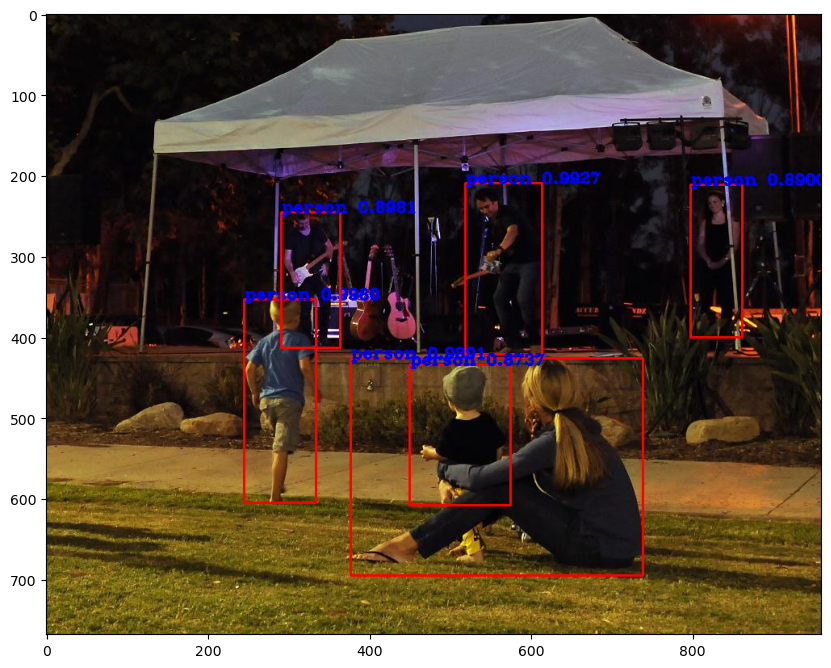

boxes.shape  : (1, 6, 4) [[[0.25598612 0.46093556 0.34825668 0.7889193 ]
  [0.5415868  0.27246565 0.64019865 0.54840636]
  [0.39337915 0.55517614 0.76979977 0.90593624]
  [0.30347428 0.31937084 0.37986782 0.537871  ]
  [0.83202887 0.2751653  0.89802265 0.5213806 ]
  [0.46920866 0.566058   0.599307   0.7924734 ]]]
scores.shape : (1, 6) [[0.9980063  0.99266016 0.9891482  0.89808106 0.88995093 0.87374204]]
classes.shape: (1, 6) [[0. 0. 0. 0. 0. 0.]]
nums.shape   : (1,) [6]


In [54]:
boxes, scores, classes, nums = predict(all_image_paths[0], figsize = (10, 10))
print('boxes.shape  :', boxes.shape,   boxes)
print('scores.shape :', scores.shape,  scores)
print('classes.shape:', classes.shape, classes)
print('nums.shape   :', nums.shape,    nums)

In [49]:
def get_prediction_entry(i, boxes, scores, classes, nums):
    return {
        "ImageID": all_image_ids[i],
        "PredictionString": get_prediction_string(boxes, scores, classes, nums)
    }

In [50]:
predictions = [get_prediction_entry(i, boxes[0], scores[0], classes[0], nums) for i in range(99999)]

In [51]:
predictions_df = pd.DataFrame(predictions)
predictions_df

,ImageID,PredictionString
0,15fe48f0b21740d2,0.0 0.9987254 0.40924034 0.03302428 0.5960367 ...
1,1e0efd102f2c709c,0.0 0.9987254 0.40924034 0.03302428 0.5960367 ...
2,37c7cab80d9d1277,0.0 0.9987254 0.40924034 0.03302428 0.5960367 ...
3,1e97ba8811bdc541,0.0 0.9987254 0.40924034 0.03302428 0.5960367 ...
4,97889265307d0ca7,0.0 0.9987254 0.40924034 0.03302428 0.5960367 ...
...,...,...
99994,6b68fc8c7b5464a1,0.0 0.9987254 0.40924034 0.03302428 0.5960367 ...
99995,10e0e06c1050f5b2,0.0 0.9987254 0.40924034 0.03302428 0.5960367 ...
99996,8265ffca975d51e5,0.0 0.9987254 0.40924034 0.03302428 0.5960367 ...
99997,c3feecd43bccbbb0,0.0 0.9987254 0.40924034 0.03302428 0.5960367 ...


In [52]:
submission_df = pd.read_csv(DIR_PATH+'sample_submission.csv')
submission_df.update(predictions_df)

In [65]:
submission_df.to_csv('./prediction.csv', index=False)